In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Added Dataset

In [ ]:
df=pd.read_csv('english_dataset.tsv',sep='\t')

In [ ]:
df.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


# Replaced all username

In [ ]:
df['text'] = df['text'].replace(r'@[^\s]+', value='', regex=True)


In [ ]:
df['text'].head()

0    #DhoniKeepsTheGlove | WATCH: Sports Minister K...
1     No. We should remember very clearly that #Ind...
2     Guess who would be the winner of this #CWC19?...
3    Corbyn is too politically intellectual for #Bo...
4    All the best to #TeamIndia for another swimmin...
Name: text, dtype: object

# Removed all special characters

In [ ]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['text'] = df['text'].str.replace(char, ' ')

In [ ]:
df['text'].head()

0     DhoniKeepsTheGlove   WATCH  Sports Minister K...
1     No  We should remember very clearly that  Ind...
2     Guess who would be the winner of this  CWC19 ...
3    Corbyn is too politically intellectual for  Bo...
4    All the best to  TeamIndia for another swimmin...
Name: text, dtype: object

In [ ]:
df

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,DhoniKeepsTheGlove WATCH Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,No We should remember very clearly that Ind...,HOF,HATE,TIN
2,hasoc_en_3,Guess who would be the winner of this CWC19 ...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to TeamIndia for another swimmin...,NOT,NONE,NONE
...,...,...,...,...,...
5847,hasoc_en_5848,That s cute and all but absolutely NOT TRUE...,HOF,PRFN,UNT
5848,hasoc_en_5849,a recession issa comin maga magamyass fuck...,NOT,NONE,NONE
5849,hasoc_en_5850,DoctorsFightBack Will The Mad n Irrational ...,HOF,OFFN,TIN
5850,hasoc_en_5851,ShiningIndia educatedindia or more like RUND...,HOF,OFFN,UNT


# Removed URLs ,including tweets URLs

In [ ]:
df['text'] = df['text'].replace(to_replace=r'^https?:\/\/.*[\r\n]*',value='',regex=True)


In [ ]:
df

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,DhoniKeepsTheGlove WATCH Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,No We should remember very clearly that Ind...,HOF,HATE,TIN
2,hasoc_en_3,Guess who would be the winner of this CWC19 ...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to TeamIndia for another swimmin...,NOT,NONE,NONE
...,...,...,...,...,...
5847,hasoc_en_5848,That s cute and all but absolutely NOT TRUE...,HOF,PRFN,UNT
5848,hasoc_en_5849,a recession issa comin maga magamyass fuck...,NOT,NONE,NONE
5849,hasoc_en_5850,DoctorsFightBack Will The Mad n Irrational ...,HOF,OFFN,TIN
5850,hasoc_en_5851,ShiningIndia educatedindia or more like RUND...,HOF,OFFN,UNT


# Lowercased all the dataframe column entries

In [ ]:
  df['text']= df['text'].str.lower()

In [ ]:
df

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,dhonikeepstheglove watch sports minister k...,NOT,NONE,NONE
1,hasoc_en_2,no we should remember very clearly that ind...,HOF,HATE,TIN
2,hasoc_en_3,guess who would be the winner of this cwc19 ...,NOT,NONE,NONE
3,hasoc_en_4,corbyn is too politically intellectual for bo...,NOT,NONE,NONE
4,hasoc_en_5,all the best to teamindia for another swimmin...,NOT,NONE,NONE
...,...,...,...,...,...
5847,hasoc_en_5848,that s cute and all but absolutely not true...,HOF,PRFN,UNT
5848,hasoc_en_5849,a recession issa comin maga magamyass fuck...,NOT,NONE,NONE
5849,hasoc_en_5850,doctorsfightback will the mad n irrational ...,HOF,OFFN,TIN
5850,hasoc_en_5851,shiningindia educatedindia or more like rund...,HOF,OFFN,UNT


In [ ]:
df.head(10)

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,dhonikeepstheglove watch sports minister k...,NOT,NONE,NONE
1,hasoc_en_2,no we should remember very clearly that ind...,HOF,HATE,TIN
2,hasoc_en_3,guess who would be the winner of this cwc19 ...,NOT,NONE,NONE
3,hasoc_en_4,corbyn is too politically intellectual for bo...,NOT,NONE,NONE
4,hasoc_en_5,all the best to teamindia for another swimmin...,NOT,NONE,NONE
5,hasoc_en_6,i hope you remembered to wipe the blood off ...,NOT,NONE,NONE
6,hasoc_en_7,latest design of wc2019 trophy cwc2019 cw...,NOT,NONE,NONE
7,hasoc_en_8,ados trendingnow blacklivesmatter justice ...,HOF,PRFN,TIN
8,hasoc_en_9,thanks for your support wow 600k graffiti ha...,NOT,NONE,NONE
9,hasoc_en_10,by wearing the balidaanbadge over his gloves ...,NOT,NONE,NONE


In [ ]:
def roc_auc(predictions, target):

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
train_data=df
test=pd.read_csv('hasoc2019_en_test-2919.tsv',sep='\t')


In [ ]:
train_data.drop(['task_2','task_3'],axis=1,inplace=True)



In [ ]:
train_data = pd.get_dummies(train_data, columns=['task_1'])

In [ ]:
train = train_data.loc[:12000,:]
train.drop(['task_1_NOT'],axis=1,inplace=True)
train.head()

,text_id,text,task_1_HOF
0,hasoc_en_1,dhonikeepstheglove watch sports minister k...,0
1,hasoc_en_2,no we should remember very clearly that ind...,1
2,hasoc_en_3,guess who would be the winner of this cwc19 ...,0
3,hasoc_en_4,corbyn is too politically intellectual for bo...,0
4,hasoc_en_5,all the best to teamindia for another swimmin...,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(train_data.text, train_data.task_1_HOF, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
ytest.shape

(1171,)

In [ ]:
token = text.Tokenizer(num_words=None)
max_len = 1500
token.fit_on_texts(list(xtrain)+list(xtest))
xtrain_seq = token.texts_to_sequences(xtrain)
xtest_seq = token.texts_to_sequences(xtest)
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)


word_index = token.word_index

In [ ]:
import os
import tensorflow as tf



# RNN

In [ ]:
  model = Sequential()
  model.add(Embedding(len(word_index)+1, 300, input_length = max_len))
  model.add(SimpleRNN(100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 300)         5604300   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 5,644,501
Trainable params: 5,644,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
history = model.fit(xtrain_pad, ytrain,
                    epochs=5,
                    batch_size=batch_size,
                    validation_data=(xtest_pad, ytest))

Epoch 1/5
74/74 [==============================] - 132s 2s/step - loss: 0.6665 - accuracy: 0.6059 - val_loss: 0.6471 - val_accuracy: 0.6234
Epoch 2/5
74/74 [==============================] - 131s 2s/step - loss: 0.5651 - accuracy: 0.7186 - val_loss: 0.6457 - val_accuracy: 0.6413
Epoch 3/5
74/74 [==============================] - 130s 2s/step - loss: 0.4061 - accuracy: 0.8846 - val_loss: 0.6673 - val_accuracy: 0.5986
Epoch 4/5
74/74 [==============================] - 131s 2s/step - loss: 0.2416 - accuracy: 0.9201 - val_loss: 0.7041 - val_accuracy: 0.5995
Epoch 5/5
60/74 [=======================>......] - ETA: 23s - loss: 0.1344 - accuracy: 0.9586

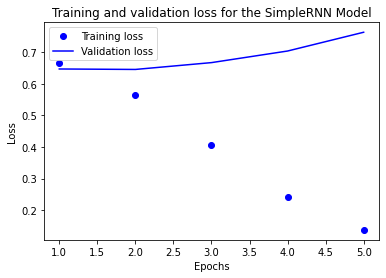

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for the SimpleRNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
scores = model.predict(xtest_pad)

print("Auc: %.2f%%" % (roc_auc(scores[:1171],ytest)))

scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores[:1171],ytest)})

Auc: 0.58%


In [ ]:

scores_model

[{'AUC_Score': 0.57814614132773, 'Model': 'SimpleRNN'}]

# MONOLINEAL

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

train
X_train = train['text']
X_test = test['text']

In [ ]:
accuracies = [[],[],[]]

In [ ]:
labels = ['0', '1']
train, test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
from sklearn.svm import LinearSVC
model2 = LinearSVC()
for category in labels:
    model2.fit(X_train, train[category])
    accuracy = model2.score(X_test, test[category])
    accuracies[1].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))

KeyError: ignored

# XLM

In [ ]:
!pip install transformers
!pip install --upgrade tensorflow

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

from tokenizers import BertWordPieceTokenizer

In [ ]:
import numpy as np
import tokenizers

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_attention_masks=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )

    return np.array(enc_di['input_ids'])

In [ ]:

AUTO = tf.data.experimental.AUTOTUNE
EPOCHS = 3
MAX_LEN = 192

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

In [ ]:
x_train = regular_encode(train.text.values, tokenizer, maxlen=MAX_LEN)

In [ ]:
x_test = regular_encode(test.task_1.values, tokenizer, maxlen=MAX_LEN)

In [ ]:
y_train = train.task_1_HOF.values
y_valid = test.task_1.values

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE=16

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(len(x_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

#SAHIL YANHA MODEL 3.2 GB KA H YE RUN KARNA PADEGA

In [ ]:
transformer_layer = (
        transformers
        .TFAutoModel.from_pretrained('jplu/tf-xlm-roberta-large')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

In [ ]:
scores = model.predict(valid_dataset)
print("Auc: %.2f%%" % (roc_auc(scores,y_valid)*100))

# BERT

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tokenizers import BertWordPieceTokenizer

In [ ]:
import numpy as np
import pandas as pd


In [ ]:

data = pd.read_csv('english_dataset.tsv',sep='t')
target_columns = list(data.columns)[2:]
y_labels = data[target_columns].values

In [ ]:
import tensorflow as tf

In [ ]:
try:

    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:

    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
MODEL = 'distilbert-base-multilingual-cased'

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(MODEL)

In [ ]:
pd.read_csv('english_dataset.tsv',sep='\t')

In [ ]:
x_train = regular_encode(train.text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.text.values, tokenizer, maxlen=MAX_LEN)

In [ ]:
y_train = train.task_1_HOF.values
y_valid = test.task_1_HOF.values


In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:

transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0]
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=4
)

In [ ]:
n_steps = x_valid.shape[0]
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=6
)

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('english_dataset.tsv',sep='\t')